# 推理引擎ONNX Runtime部署-预测单张图像

使用推理引擎 ONNX Runtime，读取 onnx 格式的模型文件，对单张图像文件进行预测。

同济子豪兄 https://space.bilibili.com/1900783

2022-8-22

## 应用场景

以下代码在需要部署的硬件上运行

只需把`onnx`模型文件发到部署硬件上，并安装 ONNX Runtime 环境，用几行代码就可以运行模型了。

## 导入工具包

In [1]:
import onnxruntime
import numpy as np
import torch

## 载入 onnx 模型，获取 ONNX Runtime 推理器

In [2]:
ort_session = onnxruntime.InferenceSession('resnet18.onnx')

## 构造输入，获取输出结果

In [8]:
x = torch.randn(1, 3, 256, 256).numpy()

In [9]:
x.shape

(1, 3, 256, 256)

In [10]:
# onnx runtime 输入
ort_inputs = {'input': x}

# onnx runtime 输出
ort_output = ort_session.run(['output'], ort_inputs)[0]

注意，输入输出张量的名称需要和 torch.onnx.export 中设置的输入输出名对应

In [11]:
ort_output.shape

(1, 1000)

In [12]:
# ort_output

## 预处理

In [23]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 载入测试图像

In [24]:
img_path = 'banana1.jpg'

In [25]:
# 用 pillow 载入
from PIL import Image
img_pil = Image.open(img_path)

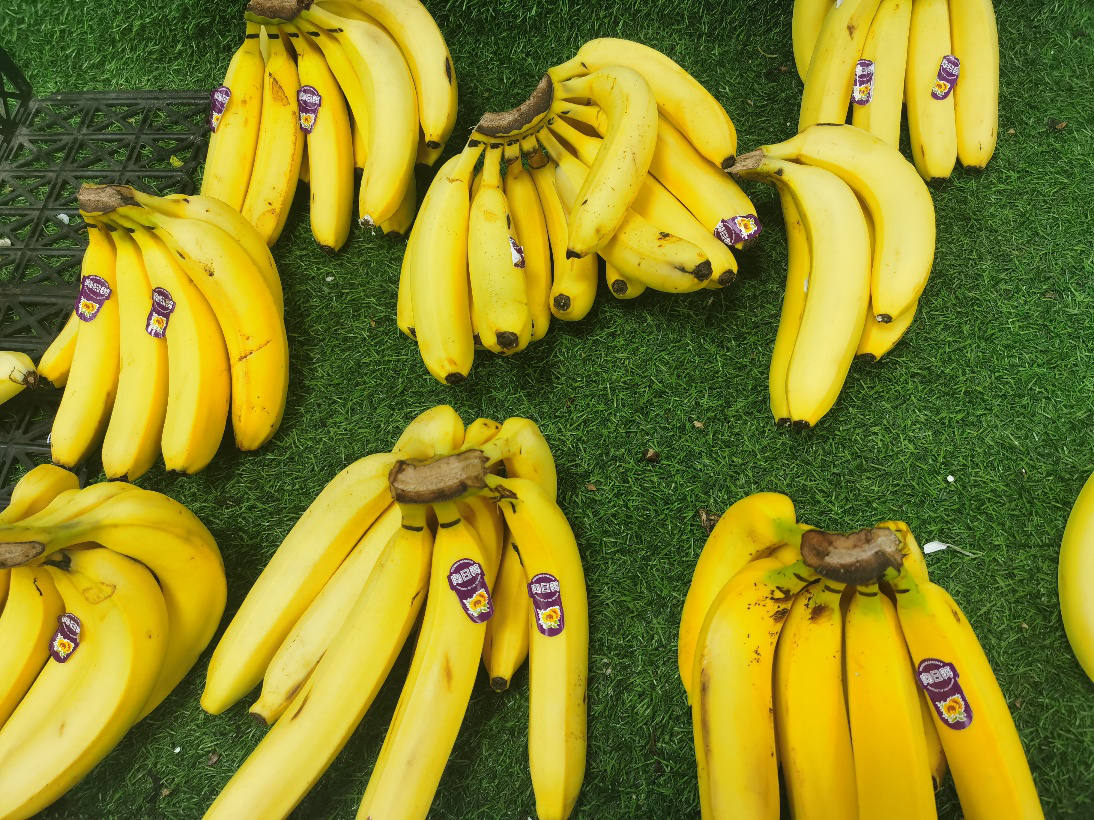

In [26]:
img_pil

## 运行预处理

In [27]:
input_img = test_transform(img_pil)

In [28]:
input_img.shape

torch.Size([3, 256, 256])

In [29]:
input_tensor = input_img.unsqueeze(0).numpy()

In [30]:
input_tensor.shape

(1, 3, 256, 256)

## ONNX Runtime预测

In [31]:
# ONNX Runtime 输入
ort_inputs = {'input': input_tensor}

In [32]:
# ONNX Runtime 输出
pred_logits = ort_session.run(['output'], ort_inputs)[0]
pred_logits = torch.tensor(pred_logits)

In [33]:
pred_logits.shape

torch.Size([1, 1000])

In [34]:
import torch.nn.functional as F
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [35]:
pred_softmax.shape

torch.Size([1, 1000])

## 柱状图可视化

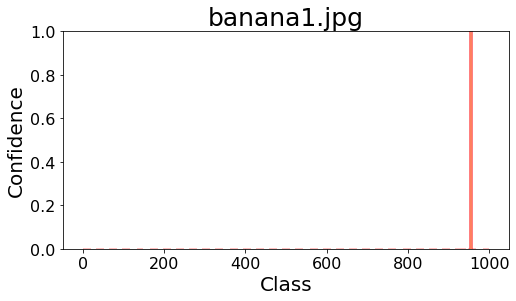

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,4))

x = range(1000)
y = pred_softmax.cpu().detach().numpy()[0]

ax = plt.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)
plt.ylim([0, 1.0]) # y轴取值范围
# plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值

plt.xlabel('Class', fontsize=20)
plt.ylabel('Confidence', fontsize=20)
plt.tick_params(labelsize=16) # 坐标文字大小
plt.title(img_path, fontsize=25)

plt.show()

后续步骤：解析top-n预测结果、在图像上写英文和中文预测结果

同原生pytorch对单张图像、视频文件、摄像头实时画面预测：https://www.bilibili.com/video/BV1qe4y1D7zD